# Simple GAN Architecture


In [1]:
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import random

In [2]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

### Read in Data

In [3]:
F_PATH = Path('img/sketch')  # fake images
R_PATH = Path('img/resize')  # real images

In [4]:
class Dataset(Dataset):
    def __init__(self, real_files, fake_files):
        self.real_files = real_files
        self.fake_files = fake_files
        
    def __len__(self):
        return len(self.real_files)
    
    def __getitem__(self, idx):
        r_path = self.real_files[idx]
        f_path = self.fake_files[idx]  
        
        r_img = cv2.imread(str(r_path)).astype(np.float32)
        f_img = cv2.imread(str(f_path)).astype(np.float32)
        
        # normalize images
        r_img = cv2.cvtColor(r_img, cv2.COLOR_BGR2RGB)/255
        f_img = cv2.cvtColor(f_img, cv2.COLOR_BGR2RGB)/255
        return np.rollaxis(r_img, 2), np.rollaxis(f_img, 2)

In [5]:
real_files = [p for p in R_PATH.iterdir()]
fake_files = [p for p in F_PATH.iterdir()]

# train test split
train = random.sample(range(1000), 800)  
valid = np.setdiff1d(range(1000), train)

In [6]:
train_ds = Dataset(real_files=[real_files[i] for i in train], 
             fake_files=[fake_files[i] for i in train])

valid_ds = Dataset(real_files=[real_files[i] for i in valid], 
             fake_files=[fake_files[i] for i in valid])

In [7]:
batch_size = 4
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Architecture

In [8]:
# U-Net based on this repo
# https://github.com/milesial/Pytorch-UNet
class Double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        """convolution -> batch norm -> relu (twice)"""
        super(Double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x
    
    
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            Double_conv(in_ch, out_ch))
    
    def forward(self, x):
        x = self.mpconv(x)
        return x
    
    
class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = Double_conv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    
    
class U_Net(nn.Module):
    def __init__(self):
        super(U_Net, self).__init__()    
        self.inconv = Double_conv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outconv = Double_conv(64, 3)
        
    def forward(self, x):
        x1 = self.inconv(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outconv(x)

In [9]:
class Generator(nn.Module):
    """given some noice, generate a fake image"""
    def __init__(self):
        super(Generator, self).__init__()
        self.unet = U_Net()
        self.f = nn.ReLU()

    def forward(self, x):
        x = self.unet(x)
        return self.f(x)

# Discriminator based on this repo
# https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/pix2pix
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        output = self.model(img_input)
        pool_out = F.adaptive_avg_pool2d(output, 1)
        return pool_out.squeeze(1).squeeze(1)

In [10]:
G = Generator().cuda()
D = Discriminator().cuda()

### Train

In [12]:
def train_epoch(epochs, lr=0.01):
    parameters_D = filter(lambda p: p.requires_grad, D.parameters())
    optimizer_D = torch.optim.Adam(parameters_D, lr=lr)
    parameters_G = filter(lambda p: p.requires_grad, G.parameters())
    optimizer_G = torch.optim.Adam(parameters_G, lr=lr)

    mse_loss = torch.nn.MSELoss()
    l1_loss = torch.nn.L1Loss()

    for i in range(epochs):
        d_total_loss = 0
        g_total_loss = 0
        total = 0
        #     D.train()
        for real_img, sketch in train_dl:
            bs = real_img.shape[0]
            valid = torch.Tensor(np.ones(bs, dtype=float)).cuda()
            fake = torch.Tensor(np.zeros(bs, dtype=float)).cuda()

            # generate fake images
            sketch = sketch.cuda()
            real_img = real_img.cuda()
            gen_img = G(sketch)

            ###################
            # TRAIN GENERATOR #
            ###################
            pred_fake = D(gen_img, sketch)

            # GAN loss
            loss_GAN = mse_loss(pred_fake, valid.unsqueeze(1))
            # Pixel-wise loss
            loss_pixel = l1_loss(gen_img, real_img)

            # Total loss
            lambda_pixel = 50
            loss_G = loss_GAN + lambda_pixel * loss_pixel
            optimizer_G.zero_grad()
            loss_G.backward(retain_graph=True)
            optimizer_G.step()

            #######################
            # TRAIN DISCRIMINATOR #
            #######################
            # Real loss
            pred_real = D(real_img, sketch)
            loss_real = mse_loss(pred_real, valid.unsqueeze(1))

            # Fake loss
            pred_fake = D(gen_img, sketch)
            loss_fake = mse_loss(pred_fake, fake.unsqueeze(1))

            # Total loss
            loss_D = 0.5 * (loss_real + loss_fake)
            optimizer_D.zero_grad()
            loss_D.backward(retain_graph=True)
            optimizer_D.step()


            d_total_loss += loss_D.item()
            g_total_loss += loss_G.item()
            total += bs

        print(f'D train loss: {d_total_loss/total} G train loss: {g_total_loss/total}')

In [11]:
train_epoch(epochs=5, lr=0.01)

D train loss: 1.667764783538878 G train loss: 5.825733367204666
D train loss: 0.060516372164711354 G train loss: 3.091893527507782
D train loss: 0.05606942031532526 G train loss: 2.925248749256134
D train loss: 0.05703434870112687 G train loss: 2.8918190252780915
D train loss: 0.052499840245582165 G train loss: 2.894084858894348


In [13]:
save_model(G, 'v1_G_model.pth')
save_model(D, 'v1_D_model.pth')

In [21]:
train_epoch(epochs=5, lr=0.005)

D train loss: 0.15202547220047563 G train loss: 2.9920696949958803
D train loss: 0.053342341361567375 G train loss: 2.8581886398792267
D train loss: 0.054634702377952635 G train loss: 2.8855679070949556
D train loss: 0.04694489717949182 G train loss: 2.8310682654380797
D train loss: 0.05817495371913537 G train loss: 2.7894763958454134


In [22]:
save_model(G, 'v2_G_model.pth')
save_model(D, 'v2_D_model.pth')

### Predict

In [13]:
def predict_all(dl):
    global count
    for real_img, sketch in dl:
        sketch = sketch.cuda()
        real_img = real_img.cuda()    
        gen_img = G(sketch)
        gen_img = gen_img.view(sketch.shape)
        for idx in range(real_img.shape[0]):
            count += 1

            s = np.rollaxis(np.rollaxis(sketch[idx].cpu().detach().numpy(), 2),2)
            pred = np.rollaxis(np.rollaxis(F.relu(gen_img[idx]).cpu().detach().numpy(), 2),2)
            actual = np.rollaxis(np.rollaxis(real_img[idx].cpu().detach().numpy(), 2),2)

            cv2.imwrite(f'output/{count}_sketch.png', s)
            cv2.imwrite(f'output/{count}_generated.png', pred)
            cv2.imwrite(f'output/{count}_actual.png', actual)

In [15]:
pred_path = Path('output')
pred_path.mkdir(exist_ok=True)

count = 0
predict_all(valid_dl)
predict_all(train_dl)

Sketch Image


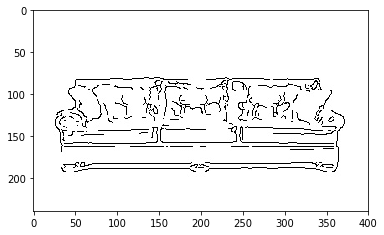

Generated Image


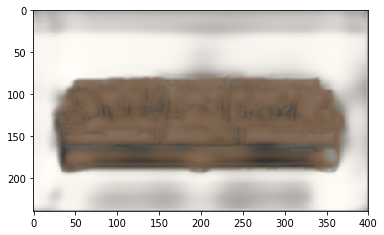

Real Image


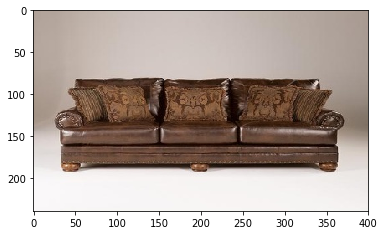

Sketch Image


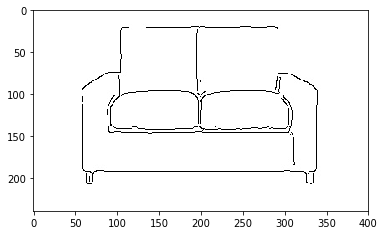

Generated Image


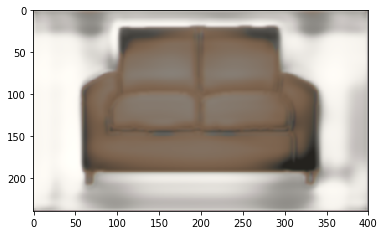

Real Image


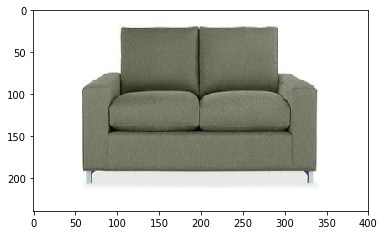

In [57]:
for idx in range(2,4):
    print('Sketch Image')
    s = np.rollaxis(np.rollaxis(sketch[idx].cpu().detach().numpy(), 2),2)
    plt.imshow(s)
    plt.show()

    print('Generated Image')
    pred = np.rollaxis(np.rollaxis(F.relu(gen_img[idx]).cpu().detach().numpy(), 2),2).clip(0, 1)
    plt.imshow(pred)
    plt.show()

    print('Real Image')
    actual = np.rollaxis(np.rollaxis(real_img[idx].cpu().detach().numpy(), 2),2)
    plt.imshow(actual)
    plt.show()